# Comprehensive Notebook of DSC 180 Wildfire Data Science Project

This is a comprehensive report-style notebook documenting all of the findings for the DSC 180 Capstone Project at UCSD.

In [26]:
import fastfuels
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rasterio
import rasterio.mask
from shapely import geometry
import geopandas as gpd
from fiona import crs

from scipy import stats

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

## Background

In 2020, the Congressional Research Service released statistics detailing how 59 wildfires burned over 10 million acres, destroying everything in its path as well as taking lives. For our project, we are focusing on preventing future wildfires through analyzing and predicting the fuels that make up certain areas, by using these labels we would be able to predict the flammability of the locations.

In order to create the labels as well as predicting the flammability, we will be using Fastfuels. FastFuels is a synthetic 3-dimensional data source which is currently being generated by the WiFIRE lab in the San Diego Supercomputer Center. The WiFIRE lab uses existing fuels and spatial data sources, such as fia plots, landfire labels, and landfire fuel type extrapolation, along with emerging AI techniques to model the 3-dimensional fuel data across the United States. It contains data on multiple characteristics of the mapped regions including surface-area-to-volume (sav), moisture, bulk density, elevation, and fuel depth.

We conducted our EDA process by querying Fastfuels sav data and comparing it to existing landfire fuel labels to observe the composition of sav data within different fuel labels.

### Accessing Landfire API fuel labels

In order to gain an understanding of how Fastfuels advances fire science and provides a greater understanding of fuels and wildfires, we needed to compare Fastfuels to the existing fuel data. Landfire is another spatial data source that has surface type data for 30 meter by 30 meter areas (pixel) in the US.

In [3]:
#src=rasterio.open(r'LF2021_FBFM40_210_CONUS/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif')
src=rasterio.open('LC21_F40_210.tif')

print(type(src))
print(src.block_shapes)
display(src.files)
print(src.is_tiled)

<class 'rasterio.io.DatasetReader'>
[(128, 128)]


['LC21_F40_210.tif']

True


In [4]:
#original numbers:
# minx, miny = -122.0003, 45
# maxx, maxy = -122, 45.0003

# example coordinates
minx, miny = -121.806464, 38.126339
maxx, maxy = -121.806164, 38.126639

bbox = geometry.box(minx, miny, maxx, maxy)

geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984

print(geo)

                                            geometry
0  POLYGON ((-121.80616 38.12634, -121.80616 38.1...


                                            geometry
0  POLYGON ((-2213370.933 1979364.929, -2213361.9...


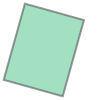

In [5]:
geo_utm=geo.to_crs(crs=src.crs.data)
print(geo_utm)
display(geo_utm.loc[0,"geometry"])

In [6]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords=getFeatures(geo_utm)
display(coords)

[{'type': 'Polygon',
  'coordinates': [[[-2213370.9326172518, 1979364.9285774315],
    [-2213361.9134944724, 1979397.321777114],
    [-2213387.008522878, 1979404.3089388362],
    [-2213396.0277479156, 1979371.9157676257],
    [-2213370.9326172518, 1979364.9285774315]]]}]

In [7]:
out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)

In [8]:
print(np.unique(out_img))

[  102 32767]


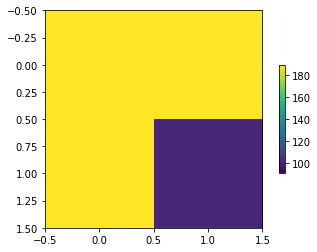

In [9]:
fig,ax=plt.subplots()

h=ax.imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
fig.colorbar(h, shrink=0.5)

Mapped data values align with the fastfuels classification of TL5, High load conifer litter, light slash or dead fuel, spread rate and flame low.

### Querying Fastfuels data

Fastfuels data is accessible through a query method and returns a dictionary containing raw data values for each of the different features mentioned earlier. Surface area to volume is our primary focus, as it represents the ratio of surface area for all vegetation/fuel in the area to the volume of vegetation in the area which helps identify fuel types based on how much potential flammable material is exposed in the voxel. We can identify a majority of the Landfire fuel labels using just the sav data, so the basis of our analysis involves utilizing the raw sav values.

In [10]:
fio = fastfuels.open('https://wifire-data.sdsc.edu:9000/fastfuels/index.fio', ftype='s3')
fio.cache_limit = 1e14

In [12]:
roi = fio.query(-122.0003, 45, 15)

Bounding box query found in single source: or_set/or_38.fio


In [13]:
print(roi.get_properties())

['bulk_density', 'sav', 'moisture', 'fuel_depth', 'elevation']


In [15]:
raw_sav_data = roi.data_dict['sav']
raw_sav_data.shape

(30, 30, 128)

### Visualizing Fastfuels data

In order to get an idea of how we can identify trends and patterns in the Fastfuels data, we visualize the data using histograms. Since the data is 3 dimensional, the baseline method of visualization is to aggregate the data by a measure of center (in this case we used average of all elevation sav values).

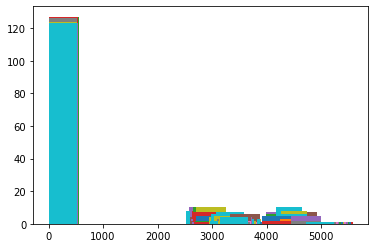

In [19]:
tree_label = []
for x in raw_sav_data:
    for y in x:
        plt.hist(y)
        if any(y[2:] != 0):
            tree_label.append(True)
        else:
            tree_label.append(False)

In [20]:
print('The label for this region is ' + str(np.unique(out_img)[0]))
print('The proportion of non-flat surface in this region is ' + str(sum(tree_label) / len(tree_label)))

The label for this region is 102
The proportion of non-flat surface in this region is 0.5722222222222222


### Dimensionality Reduction

Our goal is to find around 500 data points for each geographical feature as training points. For each of the inputted GPS coordinates, there will be a 30 x 30 x 128 sav array. The array is too large to use in the clustering model, thus we will be shrinking the data down to just a few dimensions. 

One method we will be using to reduce the dimension is the PCA. We are using PCA to shrink the 30 x 30 x 128 array down to 30 x 1 only. While some data will be lost during this dimensionality reduction, we are finally able to have smaller data sizes to feed them into the algorithm. Next, we want to compress the data again from 30 x 1 down to just 2-dimensional. To do this, we want to aggregate their values while maintaining measures of center and spread, thus calculating each 30 x 1 array’s average and standard deviation. In the final form of the array, it will have a 2-dimensional array that contains the average of the 30 x 1 numbers and the standard deviation of the 30x1 numbers.

In [22]:
def dimensionality_reduction(lat, lon):

    roi = fio.query(lon, lat, 15)
    raw_sav_data = roi.data_dict['sav']
        
    reduced = []
    
    for i in range(raw_sav_data.shape[0]):
        pca = PCA(n_components=1)
        pca_val = pca.fit_transform(raw_sav_data[i])
        #print(pca.explained_variance_ratio_)
        reduced.append((pca_val).mean())
    
    table = pd.DataFrame()
    table['numbers'] = reduced
    
    return [table['numbers'].mean(), table['numbers'].std()]

In [25]:
dimensionality_reduction(45, -122.0003) # forest

Bounding box query found in single source: or_set/or_38.fio


[2.015855352510698e-05, 7.224524597404525e-05]

### Datapoint Collection

To obtain coordinate points that we can use to train/test our clustering algorithm, we want a baseline of 500 coordinate points of each Landfire fuel label. In order to do so, we iterate through coordinate values and save the coordinate point by its fuel label. We repeat this process until we have enough desired data points.

In [29]:
def conversion(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(u'°',' ').replace('\'',' ').replace('"',' ')
    new = new.split()
    new_dir = new.pop()
    new.extend([0,0,0])
    return (int(new[0])+int(new[1])/60.0+int(new[2])/3600.0) * direction[new_dir]

lat, lon = u'''38°13'660"N, 80°19'000"W'''.split(', ')
print (conversion(lat), conversion(lon))

38.4 -80.31666666666666


In [30]:
lat = 38
long = -100 # [-86, -116]

list_coord = []
for lon in range(-106*10, -96*10):
    for lat in range(32*10, 46*10):
        list_coord.append([lat/10, lon/10])

len(list_coord)

14000

In [68]:
# grass = []
# forest = []
# counter = 0
# for coord in list_coord[100:200]:
#     print(counter)
#     counter += 1
#     fuel_type = analyze_location(coord[0], coord[1])
#     if (101 <= fuel_type <= 124):
#         grass.append(coord)
#     elif (161 <= fuel_type <= 189):
#         forest.append(coord)


0
choosing tx_set/tx_96.fio
1
choosing tx_set/tx_96.fio
2
choosing tx_set/tx_96.fio
3
Bounding box query found in single source: nm_set/nm_103.fio
4
Bounding box query found in single source: nm_set/nm_103.fio
5
Bounding box query found in single source: nm_set/nm_103.fio
6
Bounding box query found in single source: nm_set/nm_103.fio
7
Bounding box query found in single source: nm_set/nm_103.fio
8
Bounding box query found in single source: nm_set/nm_103.fio
9
Bounding box query found in single source: nm_set/nm_103.fio
10
Bounding box query found in single source: nm_set/nm_87.fio
11
Bounding box query found in single source: nm_set/nm_87.fio
12
Bounding box query found in single source: nm_set/nm_88.fio
13
Bounding box query found in single source: nm_set/nm_88.fio
14
Bounding box query found in single source: nm_set/nm_88.fio
15
Bounding box query found in single source: nm_set/nm_88.fio
16
Bounding box query found in single source: nm_set/nm_88.fio
17
Bounding box query found in sin

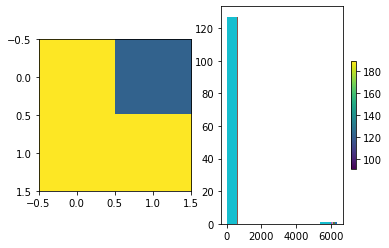

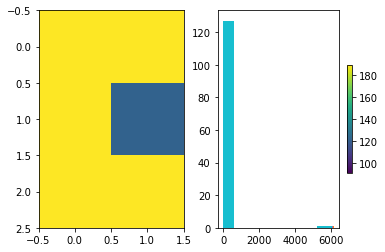

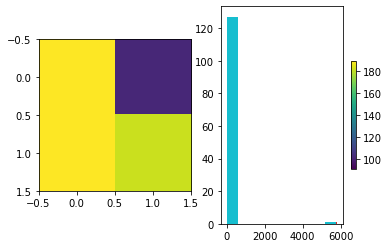

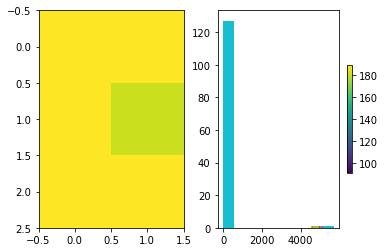

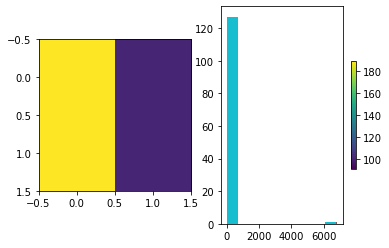

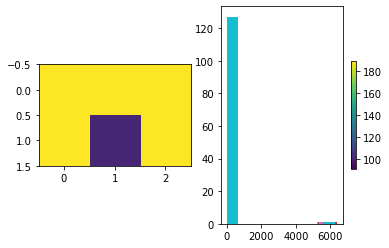

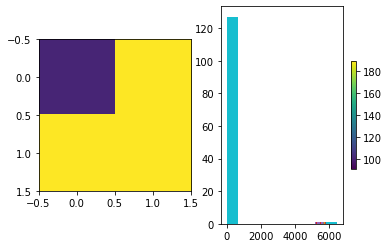

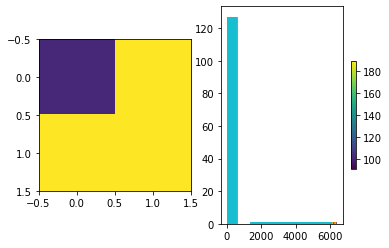

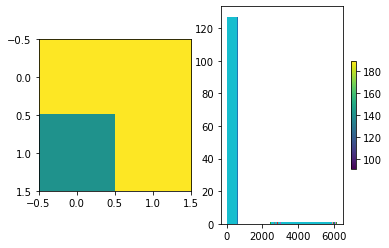

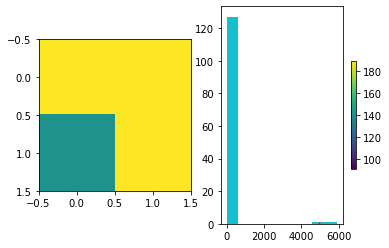

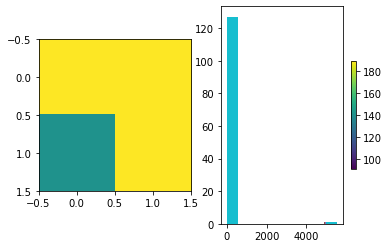

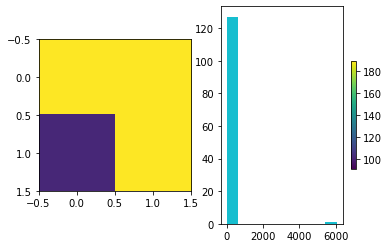

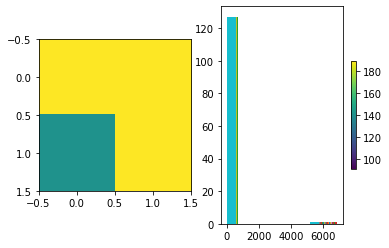

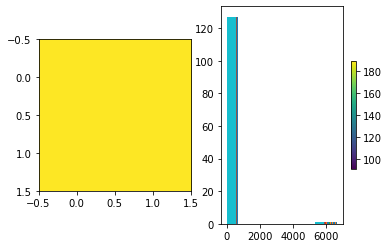

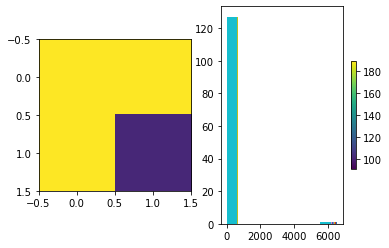

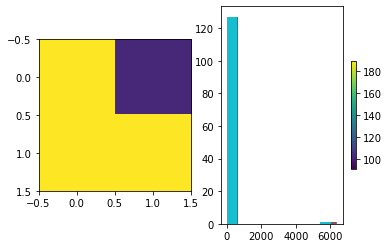

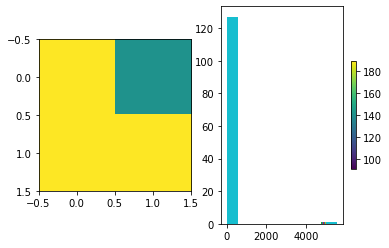

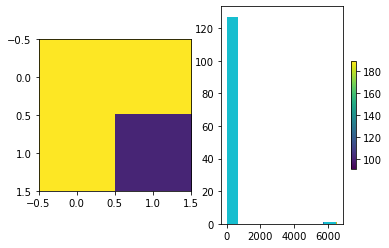

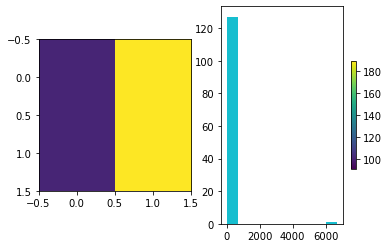

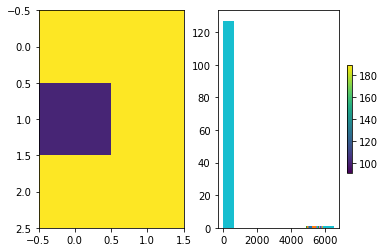

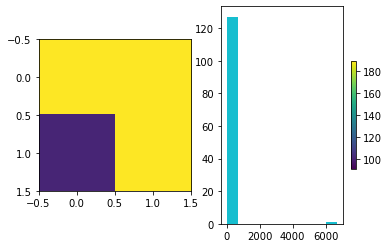

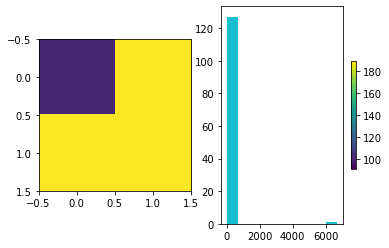

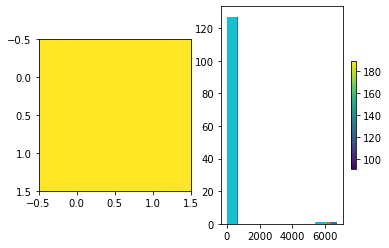

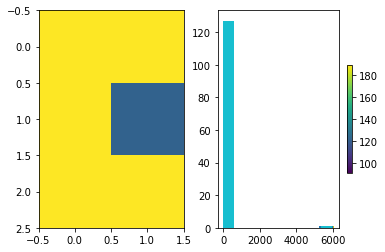

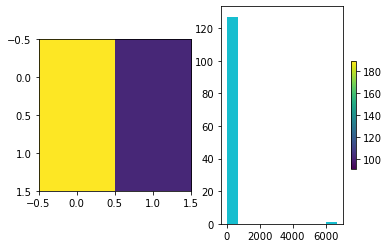

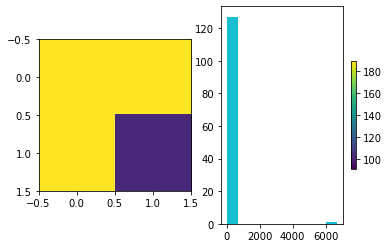

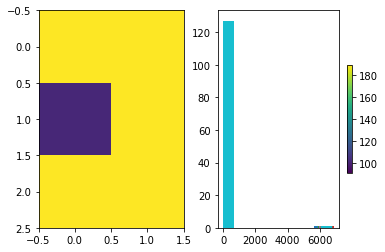

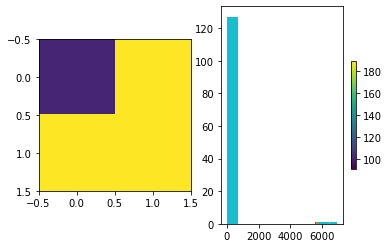

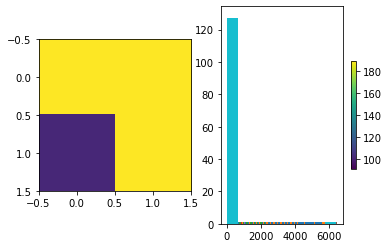

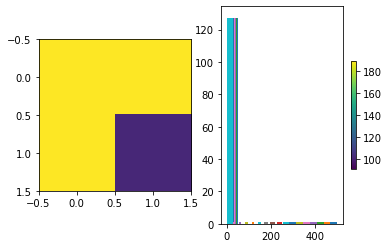

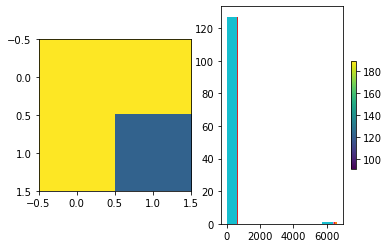

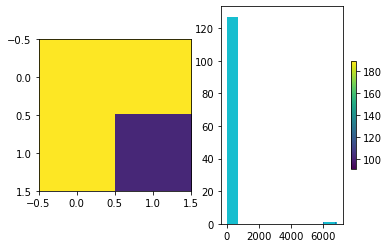

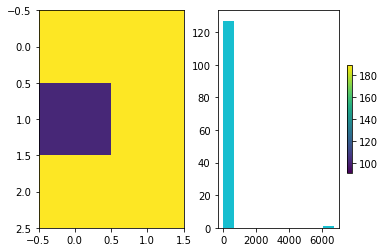

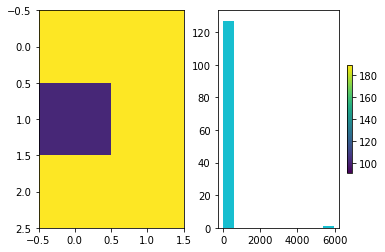

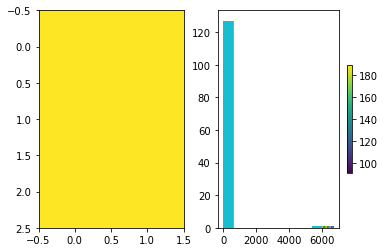

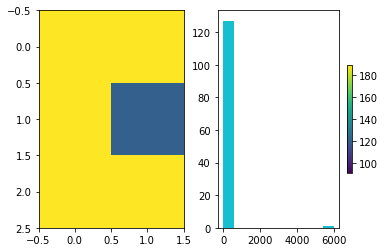

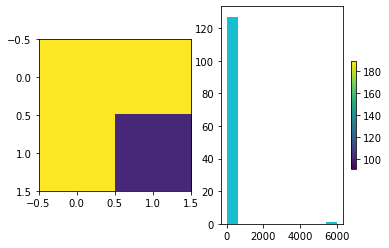

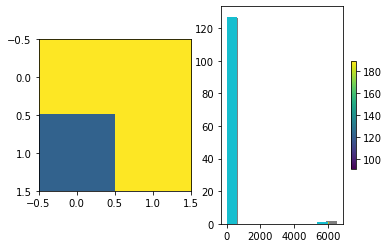

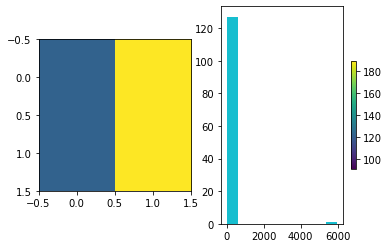

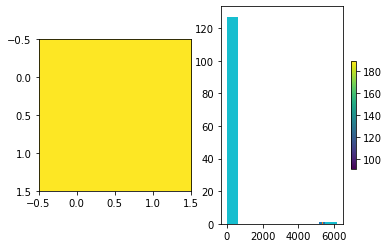

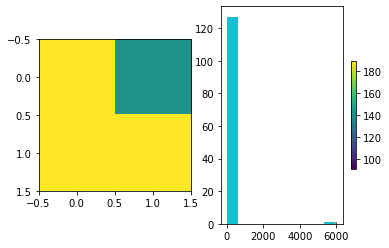

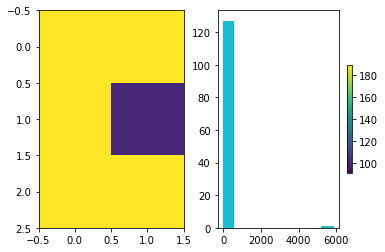

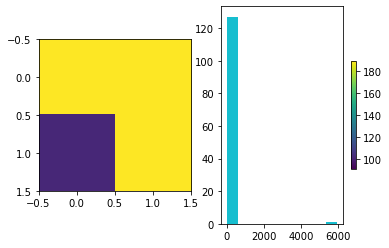

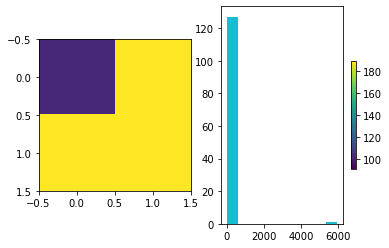

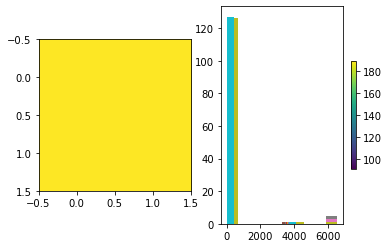

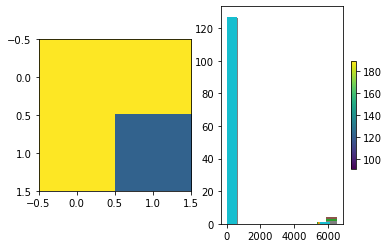

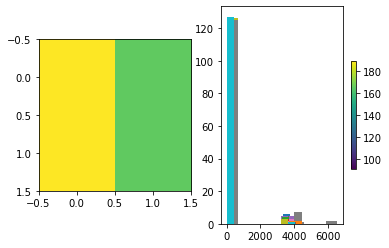

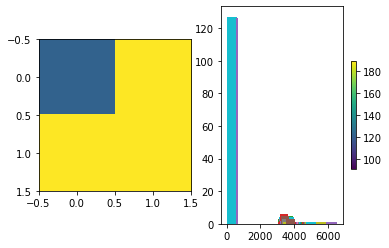

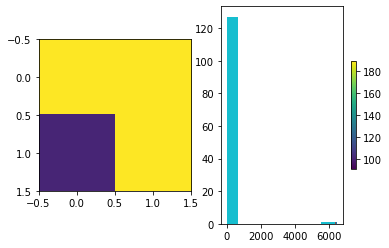

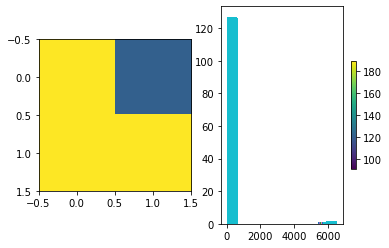

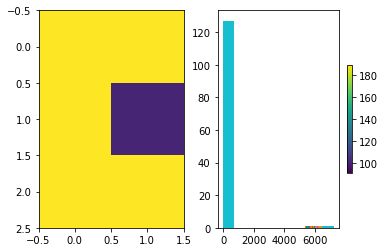

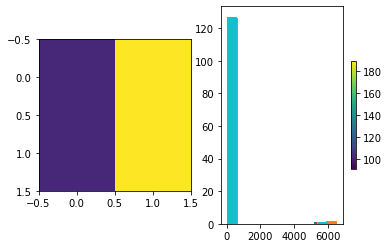

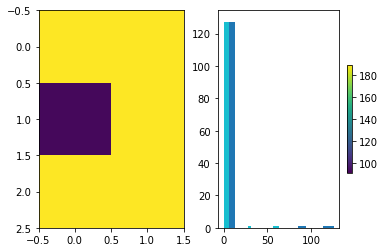

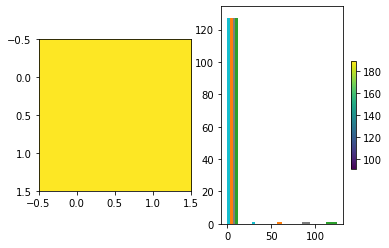

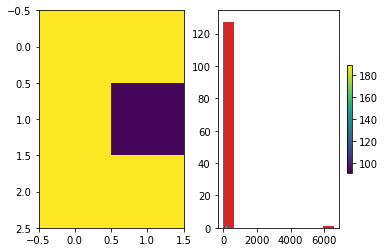

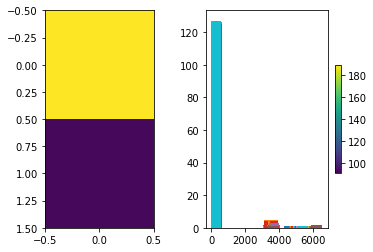

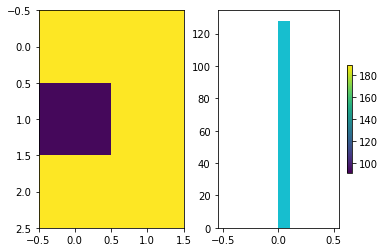

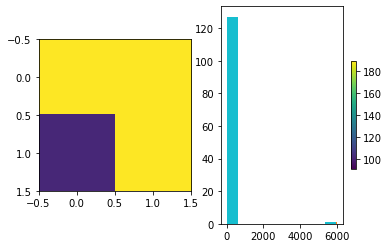

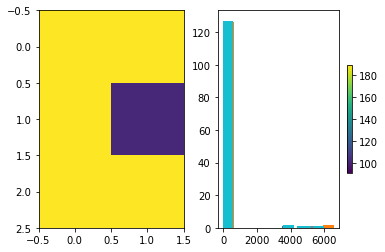

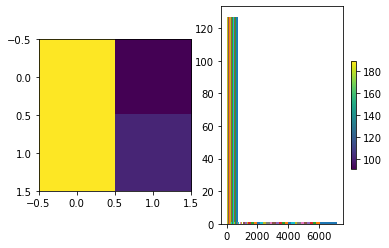

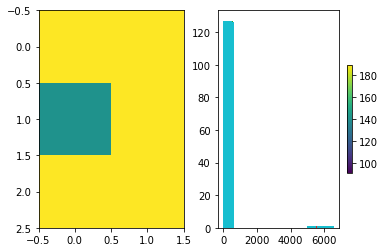

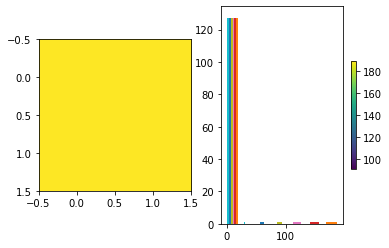

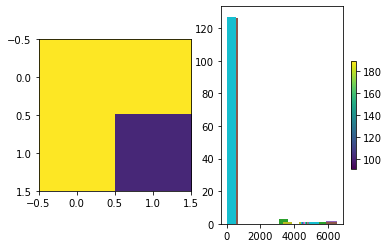

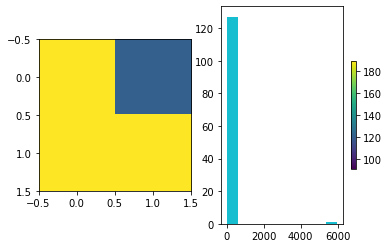

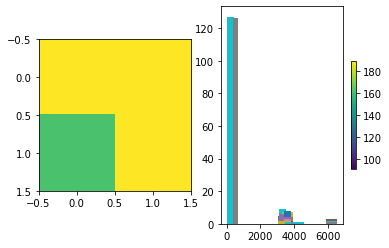

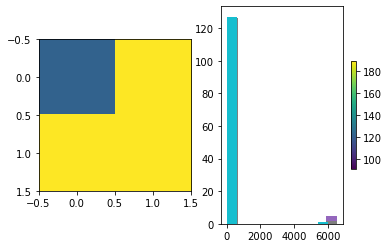

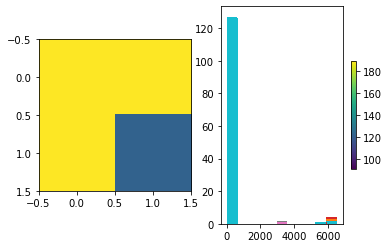

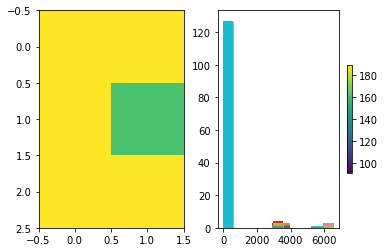

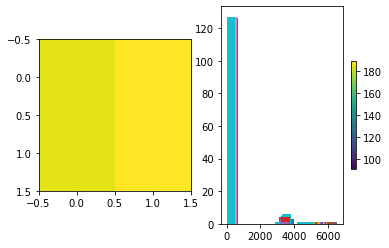

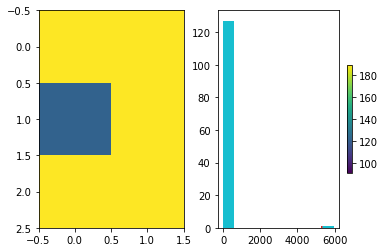

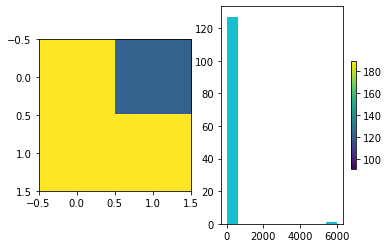

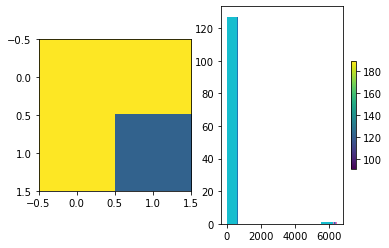

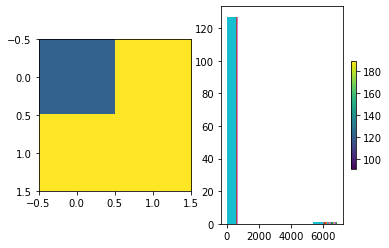

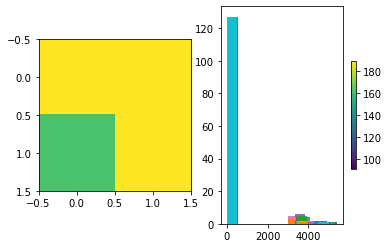

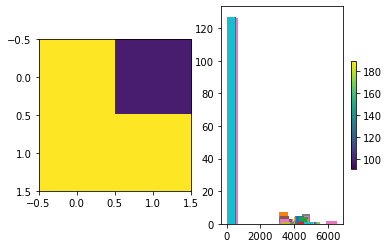

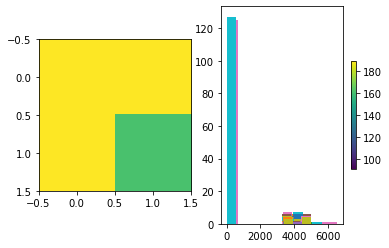

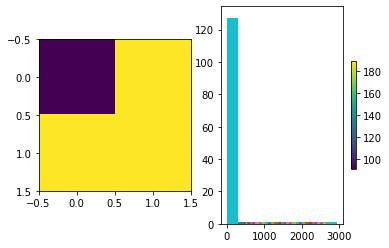

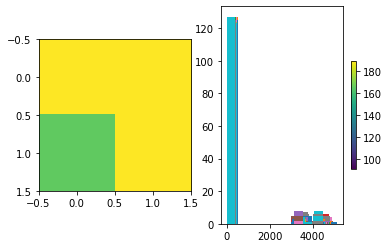

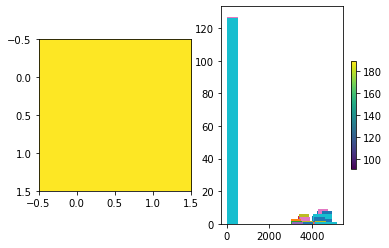

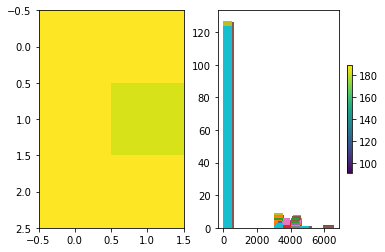

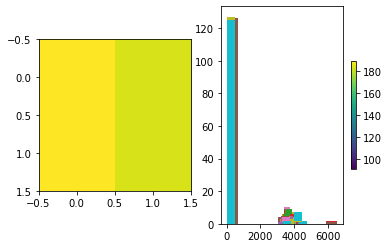

In [62]:
grass = []
forest = []
counter = 0
while (len(forest) != 10):
    print(counter)
    fuel_type = analyze_location(list_coord[counter][0], list_coord[counter][1])
    counter += 1
    if (101 <= fuel_type <= 124):
        grass.append([list_coord[counter][0], list_coord[counter][1]])
    elif (161 <= fuel_type <= 189):
        forest.append([list_coord[counter][0], list_coord[counter][1]])


In [63]:
print(len(grass))
print(len(forest))

49
10


### Clustering Implementation

At this point, we can now create a K-means clustering algorithm that predicts the label of each coordinate point and visualize it.

**more to be added soon**

In [65]:
from sklearn.cluster import KMeans

labels = []

X = []

for latlon in grass[:10] + forest:
    X.append(dimensionality_reduction(latlon[0], latlon[1]))
    
item = X
                  
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

for latlon in grass[:10] + forest:
    labels.append(kmeans.predict([dimensionality_reduction(latlon[0], latlon[1])])[0])


choosing tx_set/tx_96.fio
choosing tx_set/tx_96.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_88.fio
Bounding box query found in single source: nm_set/nm_88.fio
Bounding box query found in single source: nm_set/nm_88.fio
Bounding box query found in single source: nm_set/nm_103.fio
Bounding box query found in single source: nm_set/nm_9.fio
Bounding box query found in single source: co_set/co_151.fio
Bounding box query found in single source: co_set/co_135.fio
Bounding box query found in single source: co_set/co_135.fio
Bounding box query found in single source: co_set/co_103.fio
Bounding box query found in single source: co_set/co_87.fio
Bounding box query found in single sour

In [66]:
df = pd.DataFrame()
df['item'] = item#.tolist()
df['label'] = labels

import matplotlib.pyplot as plt

x = []
y = []

for i in df['item']:
    x.append(i[0])
    y.append(i[1])


df['x_val'] = x
df['y_val'] = y


filtered_label1 = df[df['label'] == 1]
filtered_label0 = df[df['label'] == 0]

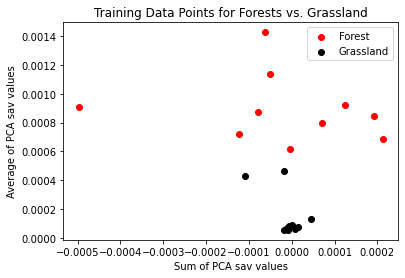

In [67]:
plt.scatter(filtered_label1['x_val'] , filtered_label1['y_val'] , color = 'red')
plt.scatter(filtered_label0['x_val'] , filtered_label0['y_val'] , color = 'black')
plt.title('Training Data Points for Forests vs. Grassland')
plt.xlabel('Sum of PCA sav values')
plt.ylabel('Average of PCA sav values')
plt.legend(['Forest', 'Grassland'])
plt.savefig('kmeans.png', bbox_inches='tight')
plt.show()

# Temporarily Ignore Below

In [27]:
labels = []
X = np.array([dimensionality_reduction(45, -122.0003),#forest
            dimensionality_reduction(32.938576, -116.684257),#grass
            dimensionality_reduction(32.885801, -116.873526),#grass
            dimensionality_reduction( 38.989042, -120.579882 ),#forest
            dimensionality_reduction( 35.19249951084869, -119.86643957481108 ),#forest
            dimensionality_reduction(43.0174, -120.2062),#grass
            dimensionality_reduction( 38.48352662411673, -123.14313953065052 ),#forest
            dimensionality_reduction( 42.808417, -119.870967 ), #grass
            dimensionality_reduction(42.92275, -113.976283),#grass
            dimensionality_reduction(44.5568, -118.8632), #forest
            dimensionality_reduction(43.683533, -122.652183),#forest
            dimensionality_reduction(47.484433, -118.94625),#grass
            dimensionality_reduction(48.096833, -121.646383),
            dimensionality_reduction(47.344283, -119.133),
            dimensionality_reduction(42.643833, -122.304883),
            dimensionality_reduction(38.296533, -80.5778)  
                 ])
item = X
                  
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels.append(kmeans.predict([dimensionality_reduction(45, -122.0003)])[0])#
labels.append(kmeans.predict([dimensionality_reduction(32.938576, -116.684257)])[0])#
labels.append(kmeans.predict([dimensionality_reduction(32.885801, -116.873526)])[0])#
labels.append(kmeans.predict([dimensionality_reduction( 38.989042, -120.579882 )])[0])#
labels.append(kmeans.predict([dimensionality_reduction( 35.19249951084869, -119.86643957481108 )])[0])#
labels.append(kmeans.predict([dimensionality_reduction(43.0174, -120.2062)])[0])#
labels.append(kmeans.predict([dimensionality_reduction(38.48352662411673, -123.14313953065052)])[0])#forest
labels.append(kmeans.predict([dimensionality_reduction(42.808417, -119.870967)])[0])#grassland
labels.append(kmeans.predict([dimensionality_reduction(42.92275, -113.976283)])[0])#grass scrub
labels.append(kmeans.predict([dimensionality_reduction(44.5568, -118.8632)])[0])#forest
labels.append(kmeans.predict([dimensionality_reduction(43.683533, -122.652183)])[0])#forest
labels.append(kmeans.predict([dimensionality_reduction(47.484433, -118.94625)])[0])#grass
labels.append(kmeans.predict([dimensionality_reduction(48.096833, -121.646383)])[0])#forest
labels.append(kmeans.predict([dimensionality_reduction(47.344283, -119.133)])[0])
labels.append(kmeans.predict([dimensionality_reduction(42.643833, -122.304883)])[0])
labels.append(kmeans.predict([dimensionality_reduction(38.296533, -80.5778)])[0])

Bounding box query found in single source: or_set/or_38.fio
Bounding box query found in single source: ca_set/ca_238.fio
Bounding box query found in single source: ca_set/ca_237.fio
Bounding box query found in single source: ca_set/ca_81.fio
Bounding box query found in single source: ca_set/ca_144.fio
Bounding box query found in single source: or_set/or_87.fio
Bounding box query found in single source: ca_set/ca_68.fio
Bounding box query found in single source: or_set/or_104.fio
Bounding box query found in single source: id_set/id_104.fio
Bounding box query found in single source: or_set/or_59.fio
Bounding box query found in single source: or_set/or_68.fio
Bounding box query found in single source: wa_set/wa_75.fio
Bounding box query found in single source: wa_set/wa_38.fio
Bounding box query found in single source: wa_set/wa_74.fio
Bounding box query found in single source: or_set/or_84.fio
Bounding box query found in single source: wv_set/wv_55.fio
Bounding box query found in single 

In [28]:
item.tolist()

[[2.015855352510698e-05, 7.224524597404525e-05],
 [0.001953125, 0.0],
 [0.00048828125, 0.0],
 [1.3393827430263627e-05, 9.514291741652414e-05],
 [0.001953125, 0.0],
 [0.00048828125, 0.0],
 [0.001953125, 0.0],
 [0.00048828125, 0.0],
 [-0.0001240190031239763, 0.00038911376032046974],
 [-5.4592546803178266e-06, 7.560414087492973e-05],
 [6.273056442296365e-06, 0.00010566074342932552],
 [0.00048828125, 0.0],
 [4.08596633860725e-06, 0.0001010133491945453],
 [0.00048828125, 0.0],
 [5.594893991656136e-06, 0.00010555841436143965],
 [3.314548303023912e-05, 8.114573574857786e-05]]

We are starting to implement the K-means clustering model, with the K-means already done we are now begining to start the classfication problem.

In [29]:
labels

[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
df = pd.DataFrame()
df['item'] = item.tolist()
df['label'] = labels

In [31]:
x = []
y = []
for i in df['item']:
    x.append(i[0])
    y.append(i[1])

df['x_val'] = x
df['y_val'] = y

filtered_label1 = df[df['label'] == 1]
filtered_label0 = df[df['label'] == 0]

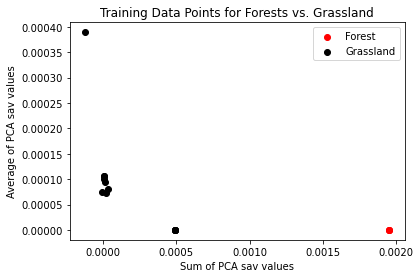

In [32]:
plt.scatter(filtered_label1['x_val'] , filtered_label1['y_val'] , color = 'red')
plt.scatter(filtered_label0['x_val'] , filtered_label0['y_val'] , color = 'black')
plt.title('Training Data Points for Forests vs. Grassland')
plt.xlabel('Sum of PCA sav values')
plt.ylabel('Average of PCA sav values')
plt.legend(['Forest', 'Grassland'])
plt.savefig('kmeans.png', bbox_inches='tight')
plt.show()

In [33]:
plt.close()